In [1]:
import json

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from gym_agents.envs import create_env
from gym_agents.agents import DQNAgent

Using TensorFlow backend.


In [2]:
filename = 'CustomMountainCar-v0-DQNAgent-config_performance.json'

In [3]:
try:
    with open(filename) as fh:
        data = json.load(fh)
except FileNotFoundError as e:
    print(f'Did not find `{filename}`. Run `python -m gym_agents` first.')

In [4]:
final_agent_config = data['agent_config']

train_episode_reward_history = data['data']['train_episode_rewards']
test_episode_reward_history = data['data_test']['test_episode_rewards']
epsilon_history = data['data']['train_epsilons']
loss_history = data['agent_history']['loss']

save_freq = data['runner_config']['save_freq']
saved_mean = data['runner_config']['saved_mean']
saved_means = data['runner_config']['saved_means']

In [5]:
print(f'Final agent config:{final_agent_config}')

Final agent config:{'gamma': 0.95, 'epsilon': 0.009998671593271896, 'epsilon_min': 0.01, 'epsilon_decay': 0.999, 'learning_rate': 0.001}


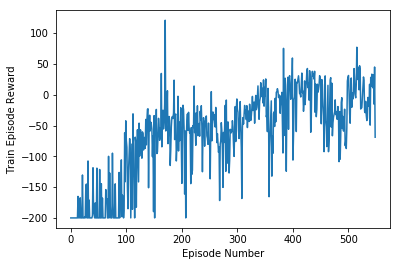

In [6]:
plt.plot(train_episode_reward_history)
plt.ylabel('Train Episode Reward')
plt.xlabel('Episode Number')
plt.show()

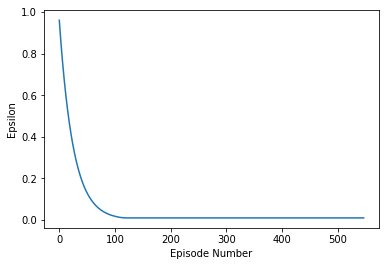

In [7]:
plt.plot(epsilon_history)
plt.ylabel('Epsilon')
plt.xlabel('Episode Number')
plt.show()

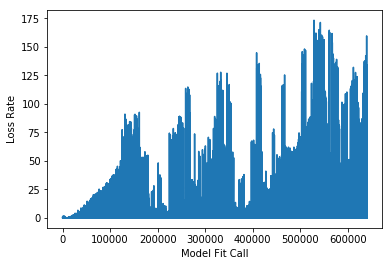

In [8]:
plt.plot(loss_history)
plt.ylabel('Loss Rate')
plt.xlabel('Model Fit Call')
plt.show()

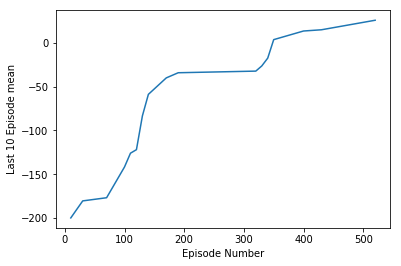

In [9]:
x = []
y = []
for mean in saved_means:
    x.append(mean['episode_num'])
    y.append(mean[f'{save_freq}_episode_mean'])
plt.plot(x, y)
plt.xlabel('Episode Number')
plt.ylabel(f'Last {save_freq} Episode mean')
plt.show()

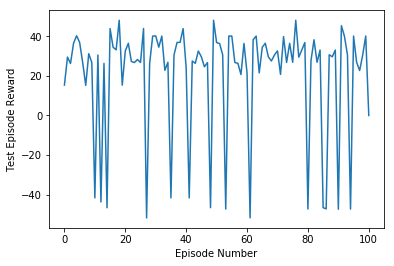

In [10]:
plt.plot(test_episode_reward_history)
plt.ylabel('Test Episode Reward')
plt.xlabel('Episode Number')
plt.show()

In [11]:
env_id = 'CustomMountainCar-v0'
agent_id = 'DQNAgent'
model_file_path = f'models/{env_id}-{agent_id}.model'

env = create_env('CustomMountainCar-v0')
agent = DQNAgent(env.action_space, env.observation_space)
agent.load(model_file_path)

In [12]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []

In [13]:
for i in range(len(X)):
    arr = np.array(([[X[i], Y[i]]]))
    action = agent.act_model(arr, None, None)
    Z.append(action)
Z = pd.Series(Z)
colors_ = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors_[x])
labels = ['Left','Nothing','Right']

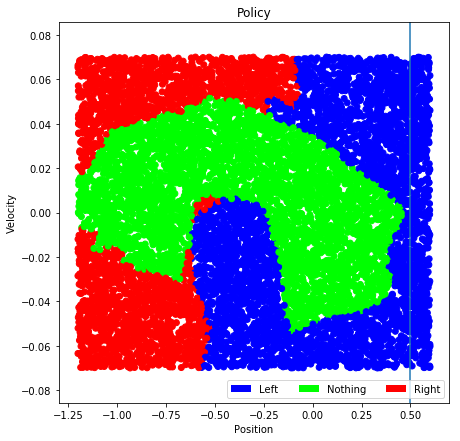

In [14]:
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(
         mpatches.Rectangle(
             (0,0),
             1,1,
             fc=sorted(colors.unique())[i]
         )
     )
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy.png')
plt.axvline(0.5)
plt.show()

In [15]:
positions = []
velocities = []
actions = []

In [16]:
state = env.reset()
state = np.reshape(state, [1, 2])
done = False
while not done:
    
    pos = state[0][0]
    vel = state[0][1]
    positions.append(pos)
    velocities.append(vel)
    
    action = agent.act_model(state, None, None)
    
    actions.append(action)
    
    state, reward, done, _ = env.step(action)
    state = np.reshape(state, [1, 2])

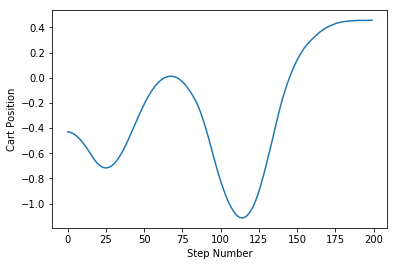

In [17]:
plt.plot(positions)
plt.xlabel('Step Number')
plt.ylabel('Cart Position')
plt.show()

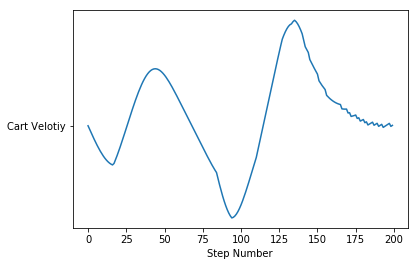

In [18]:
plt.plot(velocities)
plt.xlabel('Step Number')
plt.plot('Cart Velotiy')
plt.show()

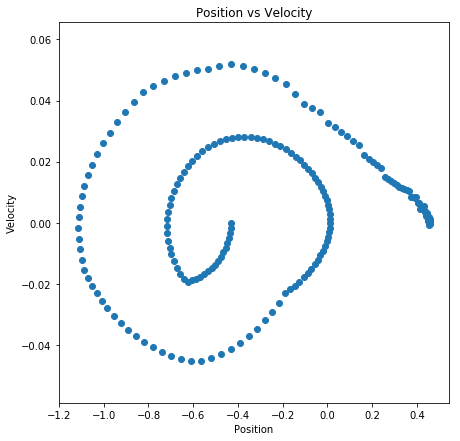

In [19]:
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
ax.scatter(positions,velocities)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Position vs Velocity')
plt.show()